In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("proj1.ipynb")

# Project 1 - SQL
## Due Date: Wednesday, September 24, 5:00pm

In this project, we will be working with SQL on the IMDb database.

## Objectives

- Explore and extract relevant information from database with SQL functions
- Perform data cleaning and transformation using string functions and regex
- Use the cleaned data to run insightful analysis using joins and aggregations functions

**Note:** If at any point during the project, the internal state of the database or its tables have been modified in an undesirable way (i.e. a modification not resulting from the instructions of a question), restart your kernel, clear output, and simply re-run the notebook as normal. This will shutdown your current connection to the database, which will prevent the issue of multiple connections to the database at any given point. When re-running the notebook, you will create a fresh database based on the provided Postgres dump.

If you face slow kernel times or are unable to open your notebook, restart your server by going to File -> Hub Control Panel -> Stop My Server and then clicking Start My Server.

## Logistics & Scoring Breakdown

Please read the submission instructions carefully and double check that your submission is not throwing any errors. Please ensure that public tests pass upon submission. It is your responsibility to wait until the autograder finishes running. We will not be accepting regrade requests for submission issues.

Each coding question has **both public tests and hidden tests**. Roughly 50% of your coding grade will be made up of your score on the public tests released to you, while the remaining 50% will be made up of unreleased hidden tests. **Free-response questions (marked 'm' in the table below) are manually graded.**

You do not need to complete the main questions in numerical order. However, **subparts of a question often build on each other and should be completed in sequence** and **Question 3 must be completed before starting Question 4**.
    
|Question|Points|
|---|---|
|0|1|
|1a|1|
|1b|2|
|1c|1|
|1d|1|
|2a|1|
|2b|3|
|2c|3|
|3a|2|
|3b|2|
|3c|2|
|3d|m: 1|
|4a|2|
|4b|m: 1|
|5|2|
|**Total**|25|

**Summary:** 25 points (autograded: 23, manual: 2) 

In [2]:
# Run this cell to set up imports
import numpy as np
import pandas as pd

## Collaboration and Inegrity

This is an **individual project**. However, you’re welcome to collaborate with any other student in the class as long as it’s within the [academic honesty guidelines](https://data101.org/fa25/syllabus/#collaboration-and-integrity).

**We ask that you list any collaborators and outside sources in the cells below.** You are expected to fill this out honestly.

### Collaborators:

Please include the first and last names of the other Data 101 students you work with on this project below.
- ex. Vicky Huang
- ...

### Outside Sources:

Please include the names and urls of any outside sources you reference for this project below.
-  ex. [SQL Help!](https://www.youtube.com/watch?v=dQw4w9WgXcQ)
- ...

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Before You Start: Assignment Tips


<p><b>Please Read!</b> In this project we will assume you have attended lecture and seen how to connect to a Postgres server via two ways: JupySQL in Jupyter Notebook, and the psql command-line program (CLI).</p>

    
We have written up these instructions for you in the <a href="https://data101.org/fa25/assignment-tips/">Fall 2025 Assignment Tips</a>—a handy resource that has many other tips that we **highly recommend** taking a moment to read through to save you time and improve your workflow:

* PostgreSQL documentation
* JupySQL and magic commands in Jupyter
* JupyterHub keyboard shortcuts
* psql and common meta-commands
* Debugging:
    * Where to create new cells to play nice with the autograder
    * Opening/closing connections, deleting databases if all else fails
* Local installation (not supported by staff officially, but for your reference)

In Jupyter Notebooks, a [cell 'magic' command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) is a special command that is preceded by two percentage signs (%%). Cell magics operate on entire cells and are used to change the behavior of the entire cell. They are not part of the Python language itself but are specific to the Jupyter environment. They help us do a lot of cool things, like run SQL commands directly within Jupyter! For some questions with cell magic, we will be saving the literal query string with [query snippets](https://jupysql.ploomber.io/en/latest/api/magic-snippets.html) using `--save`, as illustrated below:

```
%%sql --save query_result << 
SELECT * FROM table ...
```

# Database Setup
We are going to be using the `JupySQL` library to connect our notebook to a PostgreSQL database server on your JupyterHub account. Running the next cell will do so; you should not see any error messages after it executes.

In [3]:
# The first time you are running this cell, you may need to run the following line as: %load_ext sql 
%reload_ext sql

In the next cell, we will unzip the data. This only needs to be done once.

In [4]:
!unzip -u data/imdbdb.zip -d data/

Archive:  data/imdbdb.zip


<br/>

**Create the `imdb` database**: <br>
We will use PostgreSQL commands to create a database and import our data into it. Run the following cell to do this.
* You can also run these cells in the command-line via `psql`.
* If you run into the **role does not exist** error, feel free to ignore it. It does not affect data import.

In [5]:
!psql postgresql://jovyan@127.0.0.1:5432/imdb -c 'SELECT pg_terminate_backend(pg_stat_activity.pid) FROM pg_stat_activity WHERE datname = current_database()  AND pid <> pg_backend_pid();'
!psql postgresql://jovyan@127.0.0.1:5432/postgres -c 'DROP DATABASE IF EXISTS imdb'
!psql postgresql://jovyan@127.0.0.1:5432/postgres -c 'CREATE DATABASE imdb'
!psql postgresql://jovyan@127.0.0.1:5432/imdb -f data/imdbdb.sql -q

 pg_terminate_backend 
----------------------
(0 rows)

DROP DATABASE
CREATE DATABASE
 set_config 
------------
 
(1 row)



**Connect to `imdb` database in the Notebook**: 
<br>
Now let's connect to the new database we just created! There should be no errors after running the following cell.

In [7]:
%sql postgresql://jovyan@127.0.0.1:5432/imdb

Connecting to 'postgresql://jovyan@127.0.0.1:5432/imdb'

**Connect to `imdb` database in `psql`**: 

<div class="alert alert-block alert-info">
<b>Do the following in a Terminal window!</b> (To open a Terminal in DataHub, go to File -> New -> Terminal.)
</div>

Connect to the same database via `psql`. See the [Fall 2025 Assignment Tips](https://data101.org/fa25/assignment-tips/#psql-the-postgressql-interactive-cli) website resource for details on connecting. Being able to read and implement written instructions is important and crucial in working as a data engineer! To connect to the database, you should be typing in a command into your JupyterHub Terminal. Once successfully connected, you should see ``imdb=# ``

Once connected, run the following meta-command in the `psql` client:

``
\l
``

This should display all databases on this server, including the `imdb` database you just created.


---

**Quick check**: To make sure things are working, let's fetch 10 rows from one of our tables `cast_sample`. Just run the following cell, no further action is needed.

In [8]:
%%sql
SELECT * 
  FROM cast_sample
LIMIT 10

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

id,person_id,movie_id,role_id
708,235,2345369,1
721,241,2504309,1
789,264,2156734,1
875,299,1954994,1
888,302,765037,1
889,302,765172,1
898,306,291387,1
899,306,1477434,1
931,324,824119,1
1936,543,1754068,1


## Connect to the grader

In [9]:
# Connecting the grader
# Just run the following cell, no further action is needed.
from data101_utils import GradingUtil
grading_util = GradingUtil("proj1")
grading_util.prepare_autograder()

## The `imdb` Database

<div class="alert alert-block alert-danger">
<b>Read this entire section!</b> Understanding the schema is critical to doing the project correctly.
</div>

In this project, we are working with a reduced version of the [Internet Movie Database (IMDb)](https://www.imdb.com/) database. This Postgres database is a small random sample of actors from the much larger full database (which is over several GBs large) and includes their corresponding movies and cast info. Disclaimer: as a result, we may obtain wildly  different results than if we were to use the entire database. 

Below is a list of the relations in our database. Please carefully take the time to understand the references between each relations, as this will be important when querying from these relations.  
- **actor_sample**: information about the actors including id, name, and gender
- **cast_sample**: each person on the cast of each movie gets a row including cast id, each person's `id` (`actor_sample.id`), movie id (`movie_sample.id`), and role id (`role_type.id`)
- **movie_sample**: sample of movies the actors have been in, including movie id, title, and the production year
- **movie_info_sample**: this table originally had a lot of information for each movie (take a look at info_type to see the information available), but we have dropped some information to make it easier to manage. This table includes movie info's id, movie id, info type id, and the info itself
- **info_type**: reference table to match each info type id to the description of the type of information
- **role_type**: reference table for cast_sample to match role id to the description of the role

Here's an exercise for you to think about: what meta-command (in terminal/CLI) returns this bolded list?

### Key Notes
- This database is **not** the same as the IMDb lecture database, but has a lot of of similar features. 
- Point of confusion: `movie_sample` and `actor_sample` both have attributes `id` corresponding to 7 digit unique numeric identifiers, but do **not** refer to the same data values.
- `cast_sample` is analagous to the `crew` table from lecture. It can be used to match an actor's id to movies they have acted in, among other relations.
- You are highly encouraged to spend some time exploring the metadata of these tables using Postgres meta-commands to better understand the data given and the relations between tables. To get started, try outputting the schema of the tables.
- You may create unlimited CTEs, but **please do not create intermediate views** unless explicitly asked to because they may take up significant space and use up your allocated memory.
- When querying the tables from the terminal using `psql`, ensure you end every query with a semicolon (`;`). For example, to select everything from the `movie_sample` table, run `SELECT * FROM movie_sample;`

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />


# Question 0: Information Schema
There are many metadata tables that Postgres updates for us, and the full list is in the Postgres documentation [(Chapter 35)](https://www.postgresql.org/docs/current/information-schema.html).

For now, let’s look at the `.tables` table [(35.54)](https://www.postgresql.org/docs/current/infoschema-tables.html), which lists all the tables located in the database. For more information on information_schema please read the [course notes on PostgreSQL Schemas](https://data101.org/notes/3-query_perf/schemas.html#postgresql-schemas). Write a query that returns all rows referring to the six tables we described above in our `imdb` database. 

**Hints:**
* What `table_schema` do these `imdb` data tables belong to?
* Try writing a `SELECT` query that queries from `information_schema.tables`.

In [15]:
%%sql --save query_0 result_0 <<
SELECT *
FROM information_schema.tables
WHERE table_schema = 'public'
  AND table_name IN (
    'actor_sample',
    'cast_sample',
    'movie_sample',
    'movie_info_sample',
    'info_type',
    'role_type'
  );

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

6 rows affected.

In [16]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_0 = %sqlcmd snippets query_0
grading_util.save_results("result_0", query_0, result_0)
result_0

table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
imdb,public,actor_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,cast_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,info_type,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,movie_info_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,movie_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,role_type,BASE TABLE,None,None,None,None,None,YES,NO,None


In [17]:
grader.check("q0")

q0 results: All test cases passed!

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />


# Question 1: Exploratory Data Analysis
One of the first things you'll want to do with a database table is get a sense for its metadata: column names and types, and number of rows. 

## Question 1a

We can use the PostgreSQL `\d` meta-command to get a description of the `movie_info_sample` schema. Open up a terminal window, connect to the imdb server, and analyze the output of the meta-command: ``\d movie_info_sample``. This should be very similar to what you did in the Database Setup section near the top of this project notebook.


There are four attributes in this schema, of which `id` is one. What are the other attribute names? Assign `result_1a` to a list of strings, where each element is an attribute name. The list does not need to be in order.

In [18]:
result_1a = ["id", "movie_id", "info_type_id", "info"]
result_1a

['id', 'movie_id', 'info_type_id', 'info']

In [19]:
grader.check("q1a")

q1a results: All test cases passed!

**Debugging tip**: Throughout this project and when working with databases, you should always be checking schemas via the `\d` psql metacommand.

<br><br>

---

## Question 1b

Next, let’s continue with our initial exploration of this table. How many rows are in this table? 

Assign `result_1b` to the result of a SQL query to calculate the number of rows in the `movie_info_sample` table.

**Hints:**

- Your query result should have exactly one row and one attribute; the lone value in the instance should be the number of rows:

| count |
| ----- |
| SOME_INTEGER |

In [20]:
%%sql --save query_1b result_1b <<
SELECT COUNT(*) AS count
FROM movie_info_sample;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

In [21]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_1b = %sqlcmd snippets query_1b
grading_util.save_results("result_1b", query_1b, result_1b)
display(result_1b)

count
2433431


In [22]:
grader.check("q1b")

q1b results: All test cases passed!

<br><br>

---

## Question 1c: Random table sample

Now that we know a bit about the metadata of the table, let's randomly sample rows from `movie_info_sample` to explore its contents.

Given that you know the size of the table from the previous query, **write a query that retrieves 5 tuples on expectation using the `BERNOULLI` sampling method.** That is, if we run the query multiple times, we should get 5 tuples on *average* in our resulting table. The `BERNOULLI` sampling method scans the whole table and selects individual rows independently with `p%` probability. Please see the [course notes on sampling](https://data101.org/notes/1-SQL/truncation.html#sampling) for syntax.

Assign `p_1c` to a sampling rate that you pass into the `query_1c` f-string using Python variable substitution. Your formula should contain `count_1b`, which is the number of rows in the table.

If Python variable substitution is done correctly, we should be able to change our `p%` probability by simply reassigning `p_1c` and rerunning the query. (For submission please leave `p_1c` unchanged.)

We have also completed the SQL line magic for you; this references the Python f-string `query_1c` you created within a SQL query using JupySQL-specific syntax.

Once you have completed the query, try running the SQL cell many times, and see what you notice.


**Hints:**
* Don't forget to express `p_1c` in units of percent, i.e., if you want to assign it to a value of 3%, you should do `p_1c = 3` not `p_1c = 0.03`
* For a refresher on f-strings and Python variable substitution, see [this tutorial](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/).

In [24]:
query_1b, result_1b_df = grading_util.load_results("result_1b")
count_1b = result_1b_df.iloc[0, 0]
p_1c = 100 * (5 / count_1b) 
# edit this query string using variable substitution and your defined p_1c
query_1c_str = f"""
SELECT * 
FROM movie_info_sample 
TABLESAMPLE BERNOULLI ({p_1c});
"""

In [25]:
%%sql --save query_1c result_1c <<
{{query_1c_str}}

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

5 rows affected.

In [26]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_1c = %sqlcmd snippets query_1c
grading_util.save_results("result_1c", query_1c, result_1c)
result_1c

id,movie_id,info_type_id,info
4255691,401399,8,UK
5900330,1814925,3,Comedy
6954446,2483612,3,Romance
4708641,1790857,8,Brazil
6041022,1908753,3,Animation


In [27]:
grader.check("q1c")

q1c results: All test cases passed!

<br><br>

---

## Question 1d: Random sample, fixed number of rows

If a random number of rows is not of importance, a more efficient way to get some arbitrary tuples from a table is to use the `ORDER BY` and `LIMIT` clauses. In the next cell, fetch 5 **random** tuples from `movie_info_sample`. Compared to the previous question, your query result here should always have 5 tuples!

**Hint**: Check out the [course notes on sampling](https://data101.org/notes/1-SQL/truncation.html#sampling).


In [28]:
%%sql --save query_1d result_1d <<
SELECT * 
FROM movie_info_sample
ORDER BY RANDOM()
LIMIT 5;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

5 rows affected.

In [29]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_1d = %sqlcmd snippets query_1d
grading_util.save_results("result_1d", query_1d, result_1d)
result_1d

id,movie_id,info_type_id,info
6117026,1956574,3,Adult
6022021,1896909,3,Thriller
5548206,799333,3,Comedy
5541303,706983,3,Animation
9597922,2241587,1,4


In [30]:
grader.check("q1d")

q1d results: All test cases passed!

<br/><br/><br/>
<hr style="border: 1px solid #fdb515;" />


# Question 2: Data Cleaning

The `movie_sample` table contains a very minimal amount of information per movie:

In [31]:
%sql SELECT * FROM movie_sample LIMIT 5;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

5 rows affected.

id,title,production_year
2038405,La corte de faraón,1944
2081186,Long de xin,1985
2177749,Onésime aime les bêtes,1913
1718608,Bedtime Worries,1933
2130699,Mothman,2000


In this question, we’re going to create a nice, refined view of the `movie_sample` table that also includes a **rating field**, called `movie_ratings`.

The [MPAA rating](https://www.motionpictures.org/film-ratings/) is commonly included in most datasets about movies, including ours, but in its current format in the dataset, it’s quite difficult to extract.

The first clue about our approach comes from the random rows you explored in Question 1. As you saw, the `movie_info_sample` table contains a lot of information about each movie. Each row contains a particular type of information (e.g., runtime, languages) categorized by `info_type_id`. Based on the other tables in this database, the `info_type` table is a reference table to this 
ID number.

Our strategy in this question is therefore as follows:
* **Question 2a**: Find the `mpaa_rating_id` from the `info_type` table.
* **Question 2b**: Extract the MPAA rating of a specific movie from the `movie_info_sample` table.
* **Question 2c**: Construct a view `movie_ratings` based on the `movie_sample` table and all relevant MPAA ratings extracted from the `movie_info_sample` table.

<br><br>

---

## Question 2a: MPAA Rating and `info_type`

To start, using the `info_type` table, write a query to find which `id` corresponds to a film's MPAA rating.  The query `result_2a` that you write should return a relation with exactly one row and two attributes; the lone value in the instance should be the MPAA rating id number. In other words, your output table should look like this:

| id | info |
| :--- | :--- |
| SOME_INTEGER_HERE | SOME_STRING_HERE |


We've then assigned `mpaa_rating_id` to extract the number itself from the relation.

**Before you get started**:
- Open the `psql` client in a terminal to explore the schema of `info_type` via the `\d` metacommand (see the [Assignment Tips](https://data101.org/fa25/assignment-tips/) page).
- Remember you can also write SQL commands to that terminal to interact with the IMDB database, but all final work must be submitted through this Jupyter Notebook. We recommend selecting everything from the `info_type` table to see what the data looks like. Which row corresponds to the MPAA rating?

**Hints:** 
- Be careful when using quotes. SQL interprets single and double quotes differently. The single quote character `'` is reserved for delimiting string constants, while the double quote `"` is used for naming tables or columns that require special characters. See the [Postgres documentation](https://www.postgresql.org/docs/current/sql-syntax-lexical.html#SQL-SYNTAX-STRINGS) for more.

In [36]:
%%sql --save query_2a result_2a <<
SELECT id, info
FROM info_type
WHERE LOWER(info) LIKE '%mpaa%'
ORDER BY 
  CASE WHEN info = 'MPAA Rating' THEN 0 ELSE 1 END,
  id
LIMIT 1;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

In [37]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_2a = %sqlcmd snippets query_2a
grading_util.save_results("result_2a", query_2a, result_2a)
mpaa_rating_id = result_2a[0][0]
display(result_2a)
mpaa_rating_id

id,info
97,mpaa


97

In [38]:
grader.check("q2a")

q2a results: All test cases passed!

<br><br>

---

## Question 2b: Looking up the MPAA Rating

Suppose we wanted to find the MPAA rating for the 2004 American teen drama classic, _Mean Girls_. The below cell assigns `movie_id_2b` to the IMDb ID of this movie, `2109683`. Then we select the `movie_sample` data for that movie ID.

In [39]:
# Just run this cell, no further action is needed.
movie_id_2b = 2109683
%sql SELECT * FROM movie_sample WHERE id = {{movie_id_2b}};

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

id,title,production_year
2109683,Mean Girls,2004


In the next cell, **write a query to find the MPAA rating for this movie.** Your query should return a relation with exactly one row , which has columns `(info, mpaa_rating)`, where `info` is the full MPAA rating string from `movie_info_sample`, and `mpaa_rating` is just the rating itself (i.e. `R`, `PG-13`, `PG`, etc) for this movie. In other words, your output table should look like this:

| info | mpaa_rating |
| :--- | :--- |
| SOME_STRING_HERE | SOME_STRING_HERE |


**Before you get started**:

Explore the `movie_info_sample` tuples corresponding to the MPAA rating by using metacommands in the terminal. The `info` field is a little longer than just the rating. It also includes an explanation for why that movie received its rating. 

**Hints:**
* You will need to extract a substring from the `info` column of `movie_info_sample`; you can use the [string functions](https://www.postgresql.org/docs/current/functions-string.html) in PostgreSQL to do it. There are many possible solutions.
    * One possible solution is to use the `SUBSTRING` function along with regex. If you use this approach, [this section on regex](https://www.postgresql.org/docs/current/functions-matching.html#FUNCTIONS-POSIX-REGEXP) may be particularly useful.
    * Also remember that `SUBSTRING` is 1-indexed, not 0-indexed. With your chosen approach, ensure that you are returning a single element, and not an array! You may also index into an array.
    * [regex101.com](https://regex101.com) may additionally be helpful in crafting your regular expressions.
* You may use `mpaa_rating_id` (from question 2a) and `movie_id_2b` (from the code cell above) directly in the rest of the questions using Python variable substitution (i.e., using double curly braces like in the code cell above). See the `JupySQL` documentation for more details.

In [41]:
%%sql --save query_2b result_2b << 
SELECT info,
       SUBSTRING(info FROM 'Rated ([A-Z0-9-]+)') AS mpaa_rating
FROM movie_info_sample
WHERE movie_id = {{movie_id_2b}}
  AND info_type_id = {{mpaa_rating_id}};

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

In [42]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_2b = %sqlcmd snippets query_2b
grading_util.save_results("result_2b", query_2b, result_2b)
result_2b

info,mpaa_rating
"Rated PG-13 for sexual content, language and some teen partying",PG-13


In [43]:
grader.check("q2b")

q2b results: All test cases passed!

You may use `mpaa_rating_id` directly in the rest of the questions using python variable substitution.

<br><br>

---

## Question 2c
In the next cell,
1. Construct a view named `movie_ratings` containing one row for each movie, which has columns `(movie_id, title, info, mpaa_rating)`, where `info` is the full MPAA rating string from `movie_info_sample`, and `mpaa_rating` is just the rating itself (i.e. `R`, `PG-13`, `PG`, etc).
    * In other words, extend `movie_sample` with the MPAA rating attributes that you found in the previous question part, but this time for all movies instead of just one movie.      
2. Following the view definition, also write a `SELECT` query to return the **first 20 rows** of the view, ordered by ascending `movie_id`. Your table header should look like this:

| movie_id | title | info | mpaa_rating |
| -------- | ----- | ---- | ----------- |

**Note:**
* There will be some edge cases when the `info` column doesn't follow the pattern that you used in question 2b. Do not worry as long as you extract most of the ratings!

In [50]:
%%sql --save query_2c result_2c << 
DROP VIEW IF EXISTS movie_ratings;
CREATE VIEW movie_ratings AS

SELECT
  m.id AS movie_id,
  m.title,
  mi.info,
  SUBSTRING(mi.info FROM 'Rated ([A-Z0-9-]+)') AS mpaa_rating
FROM movie_sample AS m
JOIN movie_info_sample AS mi
  ON mi.movie_id = m.id
 AND mi.info_type_id = {{mpaa_rating_id}}
 AND mi.info LIKE 'Rated %';

SELECT * FROM movie_ratings
ORDER BY movie_id
LIMIT 20;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

20 rows affected.

In [51]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_2c = %sqlcmd snippets query_2c
grading_util.save_results("result_2c", query_2c, result_2c)
result_2c

movie_id,title,info,mpaa_rating
1632926,$5 a Day,"Rated PG-13 for sexual content, brief nudity and language",PG-13
1632941,$9.99,Rated R for language and brief sexuality and nudity,R
1632956,$windle,Rated R for some violence and brief sexuality/nudity,R
1633013,'A' gai wak,Rated PG-13 for violence,PG-13
1633014,'A' gai wak juk jap,Rated PG-13 for violence,PG-13
1633461,'R Xmas,"Rated R for strong language, drug content and some violence",R
1633618,'Til There Was You,"Rated PG-13 for sensuality, language and drug references",PG-13
1633729,(500) Days of Summer,Rated PG-13 for sexual material and language,PG-13
1633856,(Untitled),Rated R for language and nude images,R
1634282,.45,"Rated R for pervasive strong language including graphic sexual references, violence, sexuality and some drug use",R


In [52]:
grader.check("q2c")

q2c results: All test cases passed!

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

# Question 3: Movie Moola
One measure of a movie's success is how much money it makes. If we look at our `info_type` table, we have information about the film's gross earnings and the budget for a film. It would be nice to know how much money a film made using the profit formula:
$$profit = grossearnings - moneyspent$$

We start by taking a look at the gross earnings info type (called `gross` in the `info_type` table), with `info_type_id = 107`.

In [53]:
%%sql
SELECT * 
FROM movie_info_sample
WHERE info_type_id = 107
ORDER BY id
LIMIT 10 OFFSET 100000;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

id,movie_id,info_type_id,info
1464348,2281091,107,"INR 23,373,000 (India) (25 February 2005)"
1464349,2281091,107,"INR 19,207,000 (India) (18 February 2005)"
1464374,1766950,107,"HKD 826,364 (Hong Kong) (11 December 1975)"
1464375,1769023,107,"HKD 3,148,549 (Hong Kong) (19 November 1980)"
1464378,1799099,107,"HKD 6,493,694 (Hong Kong) (22 December 1981)"
1464383,1847670,107,"$21,438 (USA) (9 August 2009)"
1464384,1847670,107,"$10,266 (USA) (2 August 2009)"
1464396,1916002,107,"$5,932 (USA) (27 November 2005)"
1464397,1916002,107,"$4,206 (USA) (20 November 2005)"
1464398,1916002,107,"$2,939 (USA) (23 October 2005)"


There are a lot of things to notice here. First of all, the values in the `info` attribute are **strings** with not only the **earnings**, but also the **country** and the **month the earnings are cummulatively summed until**.

Additionally, the info values are **not all in the same currency**! On top of that, it appears as if **some** of the gross earnings (even for those in USD) are **from worldwide sales**, while **others only count sales within the USA**.

For consistency, let's only use movies with **gross earnings counted in the USA** and that are **in US Dollars ($)**. 

<br><br>

---

## Question 3a: Earnings
We want the numerical part of the `info` column and the **MAXIMUM earnings value** for a particular film. 

In the next cell,
- Construct a view named `movie_gross` containing **one row for each movie**, which has columns `(gross, movie_id, title)`, where `gross` is the numeric dollar amount of the **MAXIMUM earnings value** extracted as a float.
- To take a look at our cleaned data that we just created in our `movie_gross` view, write a `SELECT` query to display the **top 10 highest grossing films** from `movie_gross`. This query should occur in the same cell and should **ONLY** list your limited top 10 output. Do not use `GROUP BY` or other aggregate functions outside of your view. Your column header should look like this:

| gross | movie_id | title |
| ----- | -------- | ----- |

**Hints:** 
- The way we extracted the MPAA rating in question 2b is very similar to how we want to extract the substring containing the number and isolate the numeric dollar amount as a string. There are multiple ways of doing this.
   - Look at the [course notes for `REGEXP_REPLACE`](https://data101.org/notes/1-SQL/strings.html#regexp-replace), specifically the `'g'` flag.
   - Look at the [course notes for `SUBSTRING`](https://data101.org/notes/1-SQL/strings.html#advanced-string-functionality)
- Be careful when trying to match IDs from one relation to another relation. Take a look at the schema of the relations you are working with, whether in terminal or by referring to the description at the top of the notebook. Ensure both fields reference the same entity. For example, `movie_info_sample.id` does **NOT** refer to the same entity as `movie_sample.id`.
- Movies may have the same name! What attribute(s) to uniquely identifies a movie? Check the schema of `movie_sample`
- The staff solution found it helpful to make a CTE to create the view. You may make as many CTEs as you find necessary.

**Reminders:**
- We will only be using movies with gross earnings counted in the **USA** and that are in US Dollars (**$**). Ensure that your `info` string contains both of these markers. The `info` string contains reported gross earnings as `(non-USA)` AND `(USA)`, so please check that you are not adding extraneous values.
    - Look at the [course notes for the `LIKE` keyword](https://data101.org/notes/1-SQL/strings.html#like-not-like).
- We are looking at the gross earnings info type (called `gross` in the `info_type` table), with `info_type_id = 107`. Other `info_type_id` values correspond to different information about movies that are not relevant for this question.

<div class="alert alert-block alert-danger">
While it is fine to add CTEs, do <b>NOT</b> create additional <em>views</em> as this may take up significant space in memory. If your kernel is crashing repeatedly, check that you are not creating any views in memory.
</div>

In [54]:
%%sql
SELECT * 
FROM movie_info_sample
WHERE info_type_id = 107
AND info LIKE '%(USA)%'
ORDER BY id
LIMIT 10;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

id,movie_id,info_type_id,info
1181443,2446188,107,"$430,000 (USA)"
1181467,2354169,107,"$52,284 (USA)"
1181476,1843013,107,"$130,000 (USA)"
1181515,2391261,107,"$62,091 (USA)"
1181522,2393988,107,"$1,500,000 (USA)"
1181539,2250797,107,"$87,028 (USA)"
1181551,2415704,107,"$244,700 (USA)"
1181579,2494802,107,"$61,560 (USA)"
1181596,2345354,107,"$68,527 (USA)"
1181603,2350102,107,"$3,000,000 (USA)"


In [64]:
%%sql --save query_3a result_3a <<

DROP VIEW IF EXISTS movie_gross CASCADE;
CREATE VIEW movie_gross AS

WITH usa_gross AS (
  SELECT
    mi.movie_id,
    m.title,
    SUBSTRING(mi.info FROM '\$([0-9][0-9,]*)') AS money_str
  FROM movie_info_sample mi
  JOIN movie_sample m
    ON mi.movie_id = m.id
  WHERE mi.info_type_id = 107      
    AND mi.info LIKE '%(USA)%'     
    AND mi.info LIKE '%$%'         
    ),
cleaned AS (
  SELECT
    movie_id,
    title,
    CAST(NULLIF(REPLACE(money_str, ',', ''), '') AS DOUBLE PRECISION) AS gross
  FROM usa_gross
)
SELECT
  movie_id,
  title,
  MAX(gross) AS gross
FROM cleaned
GROUP BY movie_id, title;

SELECT gross, movie_id, title
FROM movie_gross
ORDER BY gross DESC
LIMIT 10;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [65]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_3a = %sqlcmd snippets query_3a
grading_util.save_results("result_3a", query_3a, result_3a)
result_3a

gross,movie_id,title
760507625.0,1704289,Avatar
658672302.0,2438179,Titanic
623357910.0,2346436,The Avengers
534858444.0,2360583,The Dark Knight
460935665.0,2310522,Star Wars
448139099.0,2360588,The Dark Knight Rises
436471036.0,2285018,Shrek 2
435110554.0,1851357,E.T. the Extra-Terrestrial
431065444.0,2310573,Star Wars: Episode I - The Phantom Menace
423315812.0,2204345,Pirates of the Caribbean: Dead Man's Chest


In [66]:
grader.check("q3a")

q3a results: All test cases passed!

<br/>

---

## Tutorial: Budget
We will now look at the `budget` info type, with `info_type_id = 105`.

In [67]:
%%sql
SELECT * 
FROM movie_info_sample
WHERE info_type_id = 105
ORDER BY id
LIMIT 10 OFFSET 5000;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

id,movie_id,info_type_id,info
1261074,1983149,105,"$75,000,000"
1261110,1983269,105,"INR 180,000,000"
1261160,2381188,105,"$40,000,000"
1261170,1991083,105,"FIM 9,219,499"
1261210,1993907,105,"$45,000,000"
1261247,1995787,105,"$38,000,000"
1261308,1999081,105,"$50,000,000"
1261324,1999196,105,"SEK 40,000,000"
1261375,2001114,105,"$60,000,000"
1261396,2001989,105,"$13,000,000"


Similar to when we examined the gross info, we see a lot of non-US dollar currencies. For consistency, let's only use movies **with a budget in US dollars.**

## Question 3b:

Now, we want something similar for the budget of the film, so that we can perform the subtraction of `gross` and `budget`. We want the numerical part of the `info` column and the **MAXIMUM budget value** for a particular film (as you can verify, some movies have more than one budget). 

In the next cell,
- Construct a view named `movie_budget` containing one row for each movie, which has `(budget, movie_id, title)`, where `budget` is the numeric dollar amount extracted as a float.
- To take a look at our cleaned data, write a `SELECT` query to display the **top 10 highest budget films** from `movie_budget`. When multiple films have the same budget, break ties by `movie_id` (ascending). Your column header should look like this:

| budget | movie_id | title |
| ------ | -------- | ----- |

**Hint:** The query here should be quite similar to Question 3a. Make sure to break ties properly!

In [68]:
%%sql --save query_3b result_3b <<

DROP VIEW IF EXISTS movie_budget CASCADE;
CREATE VIEW movie_budget AS

WITH usd_budget AS (
  SELECT
    mi.movie_id,
    m.title,
    SUBSTRING(mi.info FROM '\$([0-9][0-9,]*)') AS money_str
  FROM movie_info_sample mi
  JOIN movie_sample m
    ON mi.movie_id = m.id
  WHERE mi.info_type_id = 105      
    AND mi.info LIKE '%$%'         
),
cleaned AS (
  SELECT
    movie_id,
    title,
    CAST(NULLIF(REPLACE(money_str, ',', ''), '') AS DOUBLE PRECISION) AS budget
  FROM usd_budget
)
SELECT
  movie_id,
  title,
  MAX(budget) AS budget
FROM cleaned
GROUP BY movie_id, title;

SELECT budget, movie_id, title
FROM movie_budget
ORDER BY budget DESC, movie_id ASC
LIMIT 10;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [69]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_3b = %sqlcmd snippets query_3b
grading_util.save_results("result_3b", query_3b, result_3b)
result_3b

budget,movie_id,title
300000000.0,2204343,Pirates of the Caribbean: At World's End
260000000.0,2332419,Tangled
258000000.0,2305993,Spider-Man 3
250000000.0,1938937,Harry Potter and the Half-Blood Prince
250000000.0,2002374,John Carter
250000000.0,2204347,Pirates of the Caribbean: On Stranger Tides
250000000.0,2360588,The Dark Knight Rises
250000000.0,2387922,The Lone Ranger
237000000.0,1704289,Avatar
230000000.0,2344435,The Amazing Spider-Man


In [70]:
grader.check("q3b")

q3b results: All test cases passed!

<br><br>

---

## Question 3c

We now have all the parts we need to calculate the profits. Using the `movie_gross` and `movie_budget` views created above, we can now subtract the numeric columns and save the result in another column called `profit`.

In the next cell, construct a view named `movie_profit` containing one row for each movie, which has columns `(movie_id, title, profit)`, where `profit` is the result of subtracting that movie's `budget` from `gross`.

After the view definition, write a `SELECT` query to return the **first 10 rows** of the view ordered by descending `profit`. This may take a while to execute. Your column header should look like:

| movie_id | title | profit |
| -------- | ----- | ------ |

In [72]:
%%sql --save query_3c result_3c <<

DROP VIEW IF EXISTS movie_profit;
CREATE VIEW movie_profit AS

SELECT
  g.movie_id,
  g.title,
  (g.gross - b.budget) AS profit
FROM movie_gross AS g
JOIN movie_budget AS b
  ON g.movie_id = b.movie_id;

SELECT movie_id, title, profit
FROM movie_profit
ORDER BY profit DESC
LIMIT 10;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [73]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_3c = %sqlcmd snippets query_3c
grading_util.save_results("result_3c", query_3c, result_3c)
result_3c

movie_id,title,profit
1704289,Avatar,523507625.0
2438179,Titanic,458672302.0
2310522,Star Wars,449935665.0
1851357,E.T. the Extra-Terrestrial,424610554.0
2346436,The Avengers,403357910.0
2360583,The Dark Knight,349858444.0
2400712,The Passion of the Christ,340782930.0
2006991,Jurassic Park,338820792.0
2172509,Olympus Has Fallen,330824682.0
2379293,The Hunger Games,330010692.0


In [74]:
grader.check("q3c")

q3c results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 3d

We analyzed the data, but something seems odd. Upon closer look, there are many negative values for `profit`. For example, the movie `102 Dalmatians` looks to have lost around $18M, but it was a widely successful film! What may account for this issue? Think about how we constrained our data from the start of the problem.

Negative profits occur because we only used domestic gross, while budgets are global. Many films make costs internationally, so domestic-only gross minus worldwide budget could be negative. Also, some gross entries aren’t final totals, so revenue is undercounted.

<!-- END QUESTION -->

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

# Question 4: Using Cleaned Data

Now that we have cleaned our monetary records from the `info` attribute in `movie_info_sample`, let's take a closer look at the data we generated. 

<br><br>

---

## Question 4a: Analyzing Gross Earnings

A common way to view numerical data is with a boxplot. A boxplot shows a spread of the data along with several other key attributes that allow for further data analysis. 

We went through a lot of work transforming the gross earnings from strings in the`info` attribute into a numerical value. Because of our hard work, we can now further examine this data and understand its distribution. To do this, we first need to generate a [five-number summary](https://en.wikipedia.org/wiki/Five-number_summary) **and** find the average of the US gross earnings data.

- Create a view named `earnings_summary`, which consists of a one row summary of the `movie_gross` `gross` data with the `min`, `25th_percentile`, `median`, `75th_percentile`, `max`, and `average`. 
- Following the view definition, write a `SELECT` query to display it. Your query result should look like this:

| min | 25th_percentile | median | 75th_percentile | max | average |
| --- | --- | --- | --- | --- | --- |
| SOME_FLOAT_HERE | SOME_FLOAT_HERE | SOME_FLOAT_HERE | SOME_FLOAT_HERE | SOME_FLOAT_HERE | SOME_FLOAT_HERE |

**Hint:** Look at SQL [aggregate functions](https://www.postgresql.org/docs/9.4/functions-aggregate.html). You may find some useful. Also, to ensure your answer matches the autograder, **please use `percentile_cont` instead of `percentile_dis`.**

In [75]:
%%sql
select *
from movie_gross
where gross = 2136381;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

movie_id,title,gross
2129169,Morgan Stewart's Coming Home,2136381.0


In [78]:
%%sql --save query_4a result_4a <<

DROP VIEW IF EXISTS earnings_summary CASCADE;
CREATE VIEW earnings_summary AS

SELECT
  MIN(gross) AS min,
  PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY gross) AS "25th_percentile",
  PERCENTILE_CONT(0.5)  WITHIN GROUP (ORDER BY gross) AS median,
  PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY gross) AS "75th_percentile",
  MAX(gross) AS max,
  AVG(gross) AS average
FROM movie_gross;

SELECT * FROM earnings_summary;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

In [79]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_4a = %sqlcmd snippets query_4a
grading_util.save_results("result_4a", query_4a, result_4a)
result_4a

min,25th_percentile,median,75th_percentile,max,average
30.0,166623.0,2317091.0,20002717.5,760507625.0,19594424.63641884


In [80]:
grader.check("q4a")

q4a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 4b
What do you notice about the summary values generated in `earnings_summary`? We can represent the five-number summary graphically using a [box plot](https://en.wikipedia.org/wiki/Box_plot). Identify two properties about the boxplot of the data. (You do not need to explicitly create a boxplot, but think about how the summary statistics would be distributed in a boxplot.)

**Hint:** Think in terms of about concepts from statistics like spread, modality, skew, etc. and how they may apply here.

The earnings data is highly righly skewed, with a few blockbuster films earning far more than the majority, which pushes the mean above the median. At the same time, the spread is wide, with a large interquartile range and extreme high outliers. THis meaning the boxplot would show a long upper whisker and many distant points.

<Axes: >

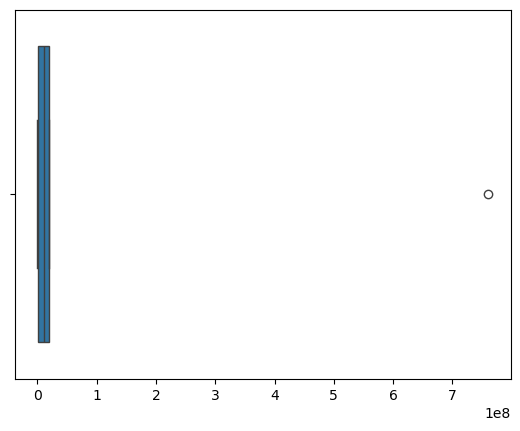

In [51]:
# optional: include your plotting code here
import seaborn as sns

sns.boxplot(result_4a.DataFrame().iloc[0].values, orient = 'h')

<!-- END QUESTION -->

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

# Question 5: Joins

Joins are a powerful tool in database cleaning and analysis. They allow for the user to create useful tables and bring together information in a meaningful way. 

There are many types of joins: inner, outer, left, right, etc. Let's practice these in a special scenario. 

You are now working as a talent director and you need a list of all people who have been in the role `actor`, **NOT** `actress`, and the number of **roles** they have acted. Of note, the original IMDB data maintains an antiquated gender binary in their encoding of roles that is not necessarily reflective of individuals' true genders.

- Create a view called `number_roles`, which has columns `id`, `name`, `number` where `id` is the actor's id, `name` is the actor's name, and `number` is the number of roles they have acted.
- Following your view, write a ``SELECT`` query to display the **top 10 actors** with the highest number of roles. Your column header should look like this:

| id | name | number |
| -- | ---- | ------ |

**Notes:**

- We recommend first exploring the `role_type` table in the terminal. Which `id` in the `role_type` corresponds to an actor?
- Ignore the `gender` column in `actor_sample`. Instead, use the role id to determine if a person is an actor or actress.
- The `cast_sample` may include actors not included in `actor_sample` table. We still want to include these actors in our result by reference to their `id`.
- The `name` field can be `NULL`.

In [82]:
%%sql --save query_5 result_5 <<
DROP VIEW IF EXISTS number_roles;
CREATE VIEW number_roles AS 

SELECT
  c.person_id AS id,
  a.name,
  COUNT(*) AS number
FROM cast_sample c
LEFT JOIN actor_sample a
  ON c.person_id = a.id
WHERE c.role_id = (
  SELECT id FROM role_type WHERE role = 'actor'
)
GROUP BY c.person_id, a.name;

SELECT id, name, number
FROM number_roles
ORDER BY number DESC
LIMIT 10;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [83]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_5 = %sqlcmd snippets query_5
grading_util.save_results("result_5", query_5, result_5)
result_5

id,name,number
95397,"Barker, Bob",6853
515315,"Freeman, Morgan",5938
677696,"Hinnant, Skip",4697
1573853,"Trebek, Alex",4690
1362169,"Sajak, Pat",3937
1417394,"Shaffer, Paul",3546
911160,"Lima, Pedro",2911
900749,"Letterman, David",2895
487253,"Filipe, Guilherme",2861
356575,"Davidson, Doug",2760


In [84]:
grader.check("q5")

q5 results: All test cases passed!

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Congratulations! You have finished Project 1.

Run the following cell to zip and download the results of your queries. You will also need to run the export cell at the end of the notebook.

**Please save your notebook before exporting (this is a good time to do it!)** Otherwise, we may not be able to register your written responses.

**For your submission on Gradescope, you will need to submit the `proj1.zip` file generated by the export cell.** Please ensure that your submission includes `proj1.pdf`, `proj1.ipynb`, and `results.zip`. 

**Please ensure that public tests pass upon submission.** It is your responsibility to wait until the autograder finishes running. We will not be accepting regrade requests for submission issues.

**Common submission issues:** You MUST submit the generated zip file to the autograder. However, Safari is known to automatically unzip files upon downloading. You can fix this by going into Safari preferences, and deselect the box with the text "Open safe files after downloading" under the "General" tab. If you experience issues with downloading via clicking on the link, you can also navigate to the project 1 directory within JupyterHub (remove `proj1.ipynb` from the url), and manually download the generated zip files. Please post on Ed if you encounter any other submission issues.

Run the following cell to zip and download the results of your queries. You will also need to run the export cell at the end of the notebook.

In [85]:
grading_util.prepare_submission_and_cleanup()

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [86]:
grader.check_all()

q0 results: All test cases passed!

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q1d results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q2c results: All test cases passed!

q3a results: All test cases passed!

q3b results: All test cases passed!

q3c results: All test cases passed!

q4a results: All test cases passed!

q5 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [87]:
# Save your notebook first, then run this cell to export your submission.
grader.export(files=['results.zip'])